In [1]:
# HIDDEN
using CSV
using DataFrames
using MLJ
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

In [106]:
# HIDDEN
df = CSV.read("water_large.csv");

In [103]:
# HIDDEN
Curve = NamedTuple{(:xs, :ys)}

flatten(seq) = [item for subseq in seq for item in subseq];

function make_curve(clf, degree, x_start=-50, x_end=50)
    fit!(clf, verbosity=0)
    xs = collect(range(-50, 50, length=100))
    ys = predict(clf, DataFrame(poly_transformer(xs, degree; include_bias=false)))
    return Curve((xs, ys))
end

function coefs(clf)
end;

## L2 Regularization: Ridge Regression

In this section we introduce $ L_2 $ regularization, a method of penalizing large weights in our cost function to lower model variance. We briefly review linear regression, then introduce regularization as a modification to the cost function.

To perform least squares linear regression, we use the model:

$$
f_\hat{\theta}(x) = \hat{\theta} \cdot x
$$

We fit the model by minimizing the mean squared error cost function:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}^n(y_i - f_\hat{\theta} (X_i))^2\\
\end{aligned}
$$

In the above definitions, $ X $ represents the $ n \times p $ data matrix, $ x $ represents a row of $ X $, $ y $ represents the observed outcomes, and $ \hat{\theta} $ represents the model weights.

## L2 Regularization Definition

To add $ L_2 $ regularization to the model, we modify the cost function above:

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_{i}^n(y_i - f_\hat{\theta} (X_i))^2
    + \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2
\end{aligned}
$$

Notice that the cost function above is the same as before with the addition of the $ L_2 $ regularization $ \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2 $ term. The summation in this term sums the square of each model weight $ \hat{\theta_1}, \hat{\theta_2}, \ldots, \hat{\theta_p} $. The term also introduces a new scalar model parameter $ \lambda $ that adjusts the regularization penalty.

The regularization term causes the cost to increase if the values in $ \hat{\theta} $ are further away from 0. With the addition of regularization, the optimal model weights minimize the combination of loss and regularization penalty rather than the loss alone. Since the resulting model weights tend to be smaller in absolute value, the model has lower variance and higher bias.

Using $ L_2 $ regularization with a linear model and the mean squared error cost function is also known more commonly as **ridge regression**.

### The Regularization Parameter

The regularization parameter $ \lambda $ controls the regularization penalty. A small $ \lambda $ results in a small penalty—if $ \lambda = 0 $ the regularization term is also $ 0 $ and the cost is not regularized at all.

A large $ \lambda $ terms results in a large penalty and therefore a simpler model. Increasing $ \lambda $ decreases the variance and increases the bias of the model. We use cross-validation to select the value of $ \lambda $ that minimizes the validation error.

**Note about regularization in `MLJ`:**

`MLJ` provides regression models that have regularization built-in through diferent packages. For example, to conduct ridge regression you may use the [`RidgeRegressor`](https://github.com/alan-turing-institute/MLJLinearModels.jl) regression model from the package `MLJLinearModels`.

`MLJ` conveniently provides regularized models that perform cross-validation to select a good value of $ \lambda $. For example, `RidgeCVRegressor` allows users to input regularization parameter values and will automatically use cross-validation to select the parameter value with the least validation error.

### Bias Term Exclusion

Note that the bias term $ \theta_0 $ is not included in the summation of the regularization term. We do not penalize the bias term because increasing the bias term does not increase the variance of our model—the bias term simply shifts all predictions by a constant value.

### Data Normalization

Notice that the regularization term $ \lambda \sum_{j = 1}^{p} \hat{\theta_j}^2 $ penalizes each $ \hat{\theta_j} $ equally. However, the effect of each $ \hat{\theta_j} $ differs depending on the data itself. Consider this section of the water flow dataset after adding degree 8 polynomial features:

In [93]:
# HIDDEN
using LinearAlgebra
using Polynomials
using Random

function poly_transformer(column, degree; include_bias=true)
    poly_matrix = Matrix(I, degree+1, degree+1)
    poly_cols = []
    for row in eachrow(poly_matrix)
        p = Poly(row)
        append!(poly_cols, [p.(column)])
    end
    if !include_bias
        return poly_cols[2:end]
    end
end;

lr_model = @load LinearRegressor pkg=ScikitLearn;

In [104]:
# HIDDEN
y = df.water_flow
X = df.water_level_change

degrees = [1, 2, 8, 12]
clf_machines = [machine(lr_model, DataFrame(poly_transformer(X, degree; include_bias=false)), y)
    for degree in degrees]

machines_df = DataFrame(hcat(degrees, clf_machines), [:degree, :machine])
curves = [make_curve(row.machine, row.degree) for row in eachrow(machines_df)];

In [105]:
# HIDDEN
df = machines_df[3, :machine].args[1]
rename!(df, [Symbol("deg_"*string(i)*"_feat") for i in 0:machines_df[3, :degree]-1])
df

,deg_0_feat,deg_1_feat,deg_2_feat,deg_3_feat,deg_4_feat,deg_5_feat,deg_6_feat
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-15.9368,253.98,-4047.62,64506.0,-1.02802e6,1.63832e7,-2.61096e8
2,-29.153,849.896,-24777.0,7.22324e5,-2.10579e7,6.139e8,-1.7897e10
3,36.1895,1309.68,47396.9,1.71527e6,6.20749e7,2.24646e9,8.12984e10
4,37.4922,1405.66,52701.4,1.97589e6,7.40805e7,2.77744e9,1.04132e11
5,-48.0588,2309.65,-1.10999e5,5.33449e6,-2.56369e8,1.23208e10,-5.92124e11
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


We can see that the degree 7 polynomial features have much larger values than the degree 1 features. This means that a large model weight for the degree 7 features affects the predictions much more than a large model weight for the degree 1 features. If we apply regularization to this data directly, the regularization penalty will disproportionately lower the model weight for the lower degree features. In practice, this often results in high model variance even after applying regularization since the features with large effect on prediction will not be affected.

To combat this, we *normalize* each data column by subtracting the mean and scaling the values in each column to be between -1 and 1. Since we will be using the model `RidgeCVRegressor` from `ScikitLearn`, we can pass `normalize=true` to normalize the data before fitting. An alternative is to use `LinearAlgebrea`'s function [`normalize`](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.normalize) to normalize the data before passing it to fit a model in case that functionality isn't available.

Another analogous technique is *standardizing* the data columns by subtracting the mean and dividing by the standard deviation for each data column. This can be done by using the data transformation functions provided by [`StatsBase`](https://juliastats.org/StatsBase.jl/stable/transformations/).

## Using Ridge Regression

We have previously used polynomial features to fit polynomials of degree 2, 8, and 12 to water flow data. The original data and resulting model predictions are repeated below.

In [108]:
# HIDDEN
df

,water_level_change,water_flow
,Float64,Float64
1,-15.9368,6.04223e10
2,-29.153,3.32149e10
3,36.1895,9.72706e11
4,37.4922,1.04288e12
5,-48.0588,7.95218e10
⋮,⋮,⋮


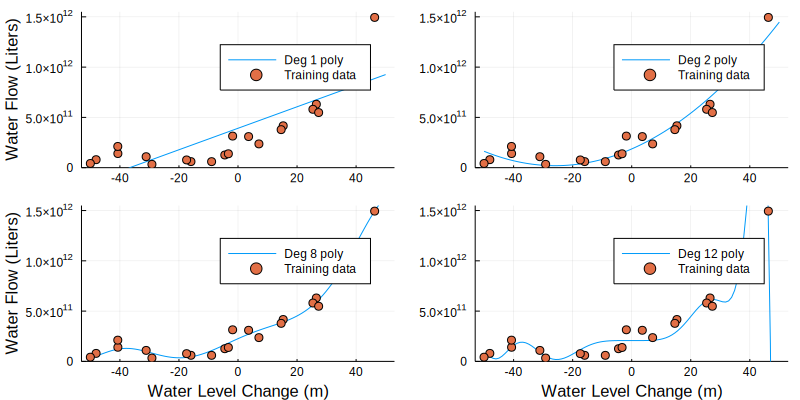

In [148]:
p1 = plot(curves[1].xs, curves[1].ys, label="Deg 1 poly", ylabel="Water Flow (Liters)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p2 = plot(curves[2].xs, curves[2].ys, label="Deg 2 poly")
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p3 = plot(curves[3].xs, curves[3].ys, label="Deg 8 poly", xlabel="Water Level Change (m)", ylabel="Water Flow (Liters)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p4 = plot(curves[4].xs, curves[4].ys, label="Deg 12 poly", xlabel="Water Level Change (m)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")

# plot_title attribute currently not implement in Plots.jl
plot(p1,p2,p3,p4, layout=4, size=(800,400), ylim=(0, 1.55e12), plot_title="Polynomial Regression")

To conduct ridge regression, we first extract the data matrix and the vector of outcomes from the data:

In [151]:
X = df.water_level_change
y = df.water_flow
println("X:", X)
println("y: ", y)

X:[-15.93675813378541, -29.15297921723813, 36.18954862666253, 37.49218733199513, -48.058829452570066, -8.941457938049757, 15.307792889226079, -40.686110015367476, -4.472010975766456, 26.53363489478886, -42.79768310017956, 25.374099383527664, -31.109553977307748, 27.311768635213408, -3.2638620136567207, -1.8182764871158748, -40.71966240251616, -50.013243645495436, -17.411771548016382, 3.588193696644129, 7.085480261970672, 46.28236901853893, 14.612289091656539]
y: [6.0422330445516914e10, 3.3214896575595245e10, 9.727063809010577e11, 1.0428825106846967e12, 7.952180125852472e10, 6.004756181442556e10, 4.1644769575877893e11, 1.4039975680142822e11, 1.2602476212624565e11, 6.306425755315374e11, -1.2420680534553963e6, 5.804626227102104e11, 1.0922974023196147e11, 5.482246480408505e11, 1.3825932502237595e11, 3.141605669976978e11, 2.1124096101481985e11, 4.181201972346732e10, 7.697952937618765e10, 3.093405575534888e11, 2.3635204652378436e11, 1.4942563810867295e12, 3.781462842479744e11]


Then, we apply a degree 12 polynomial transform to `X`. Here we are using the `poly_transform` function defined in chapter 14, but the [`MLPreprocessing`](https://github.com/JuliaML/MLPreprocessing.jl#polynomial-basis-expansion) library also offer `expand_poly` to perform polynomial basis expansion on a vector.

In [152]:
X_poly_8 = DataFrame(poly_transformer(X, 8; include_bias=false))
X_poly_8

,x1,x2,x3,x4,x5,x6,x7,x8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-15.9368,253.98,-4047.62,64506.0,-1.02802e6,1.63832e7,-2.61096e8,4.16102e9
2,-29.153,849.896,-24777.0,7.22324e5,-2.10579e7,6.139e8,-1.7897e10,5.21751e11
3,36.1895,1309.68,47396.9,1.71527e6,6.20749e7,2.24646e9,8.12984e10,2.94215e12
4,37.4922,1405.66,52701.4,1.97589e6,7.40805e7,2.77744e9,1.04132e11,3.90415e12
5,-48.0588,2309.65,-1.10999e5,5.33449e6,-2.56369e8,1.23208e10,-5.92124e11,2.84568e13
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


We specify `alpha` values that `RidgeCVRegressor` will select from using cross-validation, then use `fit!` to fit the classifier to the transformed data.

In [170]:
@load RidgeCVRegressor pkg=ScikitLearn

cv_alphas = (0.01, 0.1, 1.0, 10.0)

# Remember to set normalize=true to normalize data
rr_model = RidgeCVRegressor(alphas=cv_alphas, normalize=true)
rr_cv = machine(rr_model, X_poly_8, y)
fit!(rr_cv, verbosity=0)

# Display the chosen alpha value:
fitted_params(rr_cv).alpha

0.1

Finally, we plot the model predictions for the base degree 8 polynomial classifier next to the regularized degree 8 classifier:

In [171]:
# HIDDEN
ridge_degrees = [8, 12]
ridge_machines = [machine(rr_model, DataFrame(poly_transformer(X, degree; include_bias=false)), y)
    for degree in ridge_degrees]

ridge_machines_df = DataFrame(hcat(ridge_degrees, ridge_machines), [:degree, :machine])
ridge_curves = [make_curve(row.machine, row.degree) for row in eachrow(ridge_machines_df)];

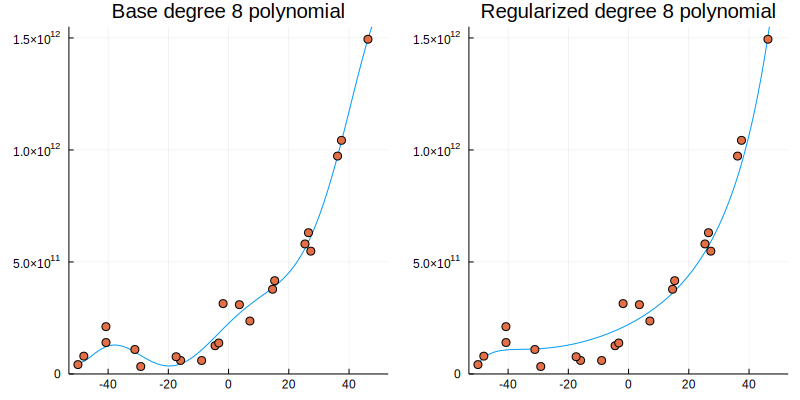

In [175]:
# HIDDEN
p1 = plot(curves[3].xs, curves[3].ys, title="Base degree 8 polynomial")
@df df scatter!(:water_level_change, :water_flow)
p2 = plot(ridge_curves[2].xs, ridge_curves[2].ys, title="Regularized degree 8 polynomial")
@df df scatter!(:water_level_change, :water_flow)

plot(p1,p2, layout=2, size=(800,400), ylim=(0, 1.55e12), legend=false)

We can see that the regularized polynomial is smoother than the base degree 8 polynomial and still captures the major trend in the data.

Comparing the coefficients of the non-regularized and regularized models shows that ridge regression favors placing model weights on the lower degree polynomial terms:

In [182]:
# HIDDEN
ridge_alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

alpha_ridge_machines = [machine(RidgeRegressor(alpha=ridge_alpha, normalize=true), DataFrame(poly_transformer(X, 12; include_bias=false)), y)
    for ridge_alpha in ridge_alphas]

alpha_ridge_machines_df = DataFrame(hcat(ridge_alphas, alpha_ridge_machines), [:alpha, :machine])
alpha_ridge_curves = [make_curve(row.machine, 12) for row in eachrow(alpha_ridge_machines_df)];

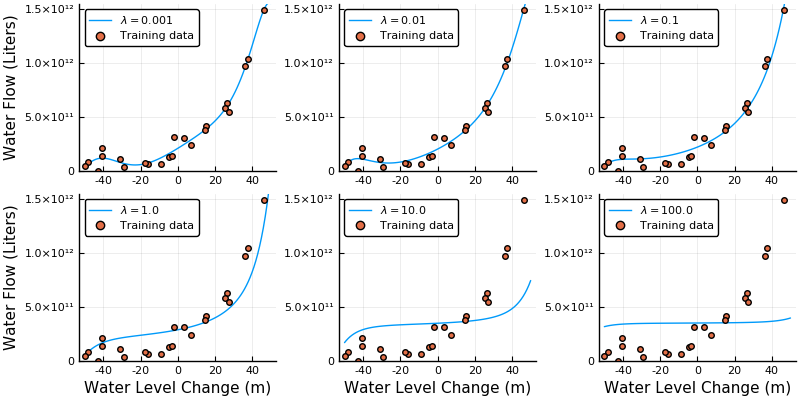

In [224]:
# HIDDEN
using LaTeXStrings
pyplot()

# TO-DO: couldn't build within a for loop
alphas_strings = string.(ridge_alphas)
p1 = plot(alpha_ridge_curves[1].xs, alpha_ridge_curves[1].ys, label=L"\lambda = " * alphas_strings[1],
    ylabel="Water Flow (Liters)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p2 = plot(alpha_ridge_curves[2].xs, alpha_ridge_curves[2].ys, label=L"\lambda = " * alphas_strings[2])
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p3 = plot(alpha_ridge_curves[3].xs, alpha_ridge_curves[3].ys, label=L"\lambda = " * alphas_strings[3])
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p4 = plot(alpha_ridge_curves[4].xs, alpha_ridge_curves[4].ys, label=L"\lambda = " * alphas_strings[4],
    xlabel="Water Level Change (m)", ylabel="Water Flow (Liters)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p5 = plot(alpha_ridge_curves[5].xs, alpha_ridge_curves[5].ys, label=L"\lambda = " * alphas_strings[5],
    xlabel="Water Level Change (m)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")
p6 = plot(alpha_ridge_curves[6].xs, alpha_ridge_curves[6].ys, label=L"\lambda = " * alphas_strings[6],
    xlabel="Water Level Change (m)")
@df df scatter!(:water_level_change, :water_flow, label="Training data")

plot(p1,p2,p3,p4,p5,p6, layout=6, size=(800,400), ylim=(0, 1.55e12))

As we can see, increasing the regularization parameter increases the bias of our model. If our parameter is too large, the model becomes a constant model because any non-zero model weight is heavily penalized.

## Summary

Using $ L_2 $ regularization allows us to tune model bias and variance by penalizing large model weights. $ L_2 $ regularization for least squares linear regression is also known by the more common name ridge regression. Using regularization adds an additional model parameter $ \lambda $ that we adjust using cross-validation.